In [1]:
import copy
import sys
import time
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

warnings.filterwarnings("ignore")


Parse the Data

In [2]:
from utils import get_data

problem = input("What problem? ")
if problem == 'infinite_slab':
    case = int(input("What case? "))
study = int(input("What study? "))

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")


Loading and formating the data...
Loading the data took 106.492636 s


Define the QoI function

In [20]:
from pyROMs import DMD, PartitionedDMD

if problem == 'three_group_sphere':
    def QoI(x):
        dmd = DMD(svd_rank=4, opt=True)
        dmd.fit(x)
        omegas = np.log(dmd.eigvals)/dt
        return omegas[np.argmax(omegas.real)]

elif problem == 'infinite_slab':
    def QoI(x):
        return np.sum(x[-1])*2.0

elif problem == 'twigl':
    def QoI(x):
        return np.sum(x[-1])*16.0

elif problem == 'lra':
    def QoI(x):
        if mode == 0:
            x = x[np.argmax(np.sum(x, axis=1))]
        return np.sum(x)*7.5**2
        # integral = 0.0
        # for i in range(130, 171):
        #     P_avg = 0.5*(np.sum(x[i + 1]) + np.sum(x[i]))*7.5**2
        #     integral += P_avg*dt
        # return integral

else:
    raise NotImplementedError(f"QoI function not implemented for {problem}")


Performing Model Validation

Performing validation...
	Mean of Mean Fold Errors:	1.421e-04
	Maximum Mean Fold Errors:	1.500e-04
	Minimum Mean Fold Errors:	1.305e-04
	Maximum of Maximum Fold Errors:	1.017e-02
	Minimum of Minimum Fold Errors:	1.166e-04
Validation took 0.261 s.
QoI:	1.369e+09
QoI:	9.927e+08


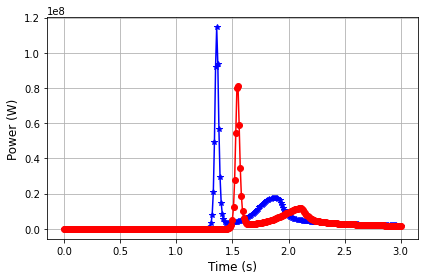

In [21]:
from pyROMs import POD, DMD
from sklearn.model_selection import KFold

mode = 1
base = "/Users/zacharyhardy/Documents/phd/dissertation/figures"

X = dataset.create_dataset_matrix(var)
Y = dataset.parameters

n_splits = 4
interior_only = True
seed = None

tau = 1.0e-10
if problem == 'three_group_sphere':
    interp = 'rbf'
    epsilon = 200.0
    filename = f"{base}/pulsed_neutron"
elif problem == 'infinite_slab':
    interp = 'rbf'
    epsilon = 1.0
    filename = f"{base}/infinite_slab"
elif problem == 'twigl':
    interp = 'rbf'
    epsilon = 20.0
    filename = f"{base}/twigl"
else:
    interp = 'rbf'
    epsilon = 500.0
    filename = f"{base}/lra"
    if "dissertation" in base:
        filename = f"{base}/chapter9"
    if mode == 1:
        X = dataset.unstack_simulation_vector(X)
        X = np.array([x[np.argmax(np.sum(x, axis=1))] for x in X])

dt = np.diff(dataset.times)[0]

print("Performing validation...")
t_start = time.time()
cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
pod = POD(svd_rank=0)
errors = {'mean': [], 'max': [], 'min': []}
for train, test in cv.split(X, Y):
    pod = pod.fit(X[train], Y[train], interp, epsilon=epsilon)
    X_pod = pod.predict(Y[test])

    if problem != 'lra' or mode == 0:
        X_test = dataset.unstack_simulation_vector(X[test])
        X_pod = dataset.unstack_simulation_vector(X_pod)
    elif mode == 1:
        X_test = X[test]

    fold_error = np.zeros(len(test))
    for i in range(len(test)):
        qoi_test = QoI(X_test[i])
        qoi_pod = QoI(X_pod[i])
        fold_error[i] = abs(qoi_test-qoi_pod)/abs(qoi_test)
    errors['mean'].append(np.mean(fold_error)/len(test))
    errors['max'].append(np.max(fold_error))
    errors['min'].append(np.min(fold_error))
t_end = time.time()
print(f"\tMean of Mean Fold Errors:\t{np.mean(errors['mean']):.3e}")
print(f"\tMaximum Mean Fold Errors:\t{np.max(errors['mean']):.3e}")
print(f"\tMinimum Mean Fold Errors:\t{np.min(errors['mean']):.3e}")
print(f"\tMaximum of Maximum Fold Errors:\t{np.max(errors['max']):.3e}")
print(f"\tMinimum of Minimum Fold Errors:\t{np.min(errors['min']):.3e}")
print(f"Validation took {t_end-t_start:.3f} s.")

plt.figure()
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Power (W)", fontsize=12)

# Get max peak power per simulation
peak_power = []
for s in range(len(dataset.simulations)):
    simulation = dataset.simulations[s]
    P_max = np.max(simulation.powers)
    peak_power.append(P_max)

# Plot min/max max peak powers over the space
styles = ['-*b', '-or']
argmin = int(np.argmin(peak_power))
argmax = int(np.argmax(peak_power))
for i, s in enumerate([argmax, argmin]):
    simulation = dataset.simulations[s]
    P = simulation.powers
    print(f"QoI:\t{QoI(simulation.power_densities):.3e}")
    plt.plot(dataset.times, P, styles[i])
plt.grid(True)
plt.tight_layout()

Fit the ROM to All Data

Fitting the ROM to all available data...
Fitting took 0.001 s.


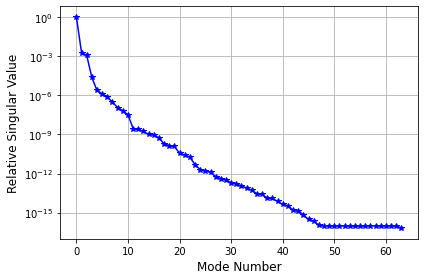

In [27]:
print("Fitting the ROM to all available data...")
t_start = time.time()
pod.fit(X, Y, interp, epsilon=epsilon)
t_end = time.time()
print(f"Fitting took {t_end-t_start:.3f} s.")

pod.plot_singular_values()
plt.savefig(f"{filename}/scree_small.pdf")

Generate Random Samples and Query the ROM


In [30]:
n_samples = int(5.0e3*4)

rng = np.random.default_rng()
bounds = dataset.parameter_bounds
samples = np.zeros((n_samples, dataset.n_parameters))
for p in range(samples.shape[1]):
    low, high = bounds[p][0], bounds[p][1]
    samples[:, p] = rng.uniform(low, high, n_samples)

qoi = np.zeros((n_samples,))
dt = np.diff(dataset.times)[0]

# POD predictions
print("Starting ROM queries...")
t_start = time.time()
X_pod = pod.predict(samples)
if problem != 'lra' or mode == 0:
    X_pod = dataset.unstack_simulation_vector(X_pod)
for i in range(n_samples):
    qoi[i] = QoI(X_pod[i])
t_end = time.time()
print(f"ROM queries took {t_end-t_start:.3f} s.")
print(f"Mean:\t{np.mean(qoi):.3e}.")
print(f"STD:\t{np.std(qoi):.3e}")

Starting ROM queries...
ROM queries took 0.164 s.
Mean:	9.855e+07.
STD:	5.805e+06


Plot the Distribution

\begin{tabular}{c|c}
	 \textbf{Quantity} & \textbf{Value} \\ \hline
	 Mean & 9.855e+07 \\
	 Median & 9.843e+07 \\
	 Std. Deviation & 5.805e+06 \\
	 95\% Conf. Interval & [8.760e+07, 1.099e+08] \\
\end{tabular}

Mean:		9.855e+07
Std. Dev.:	5.805e+06
Median:		9.843e+07


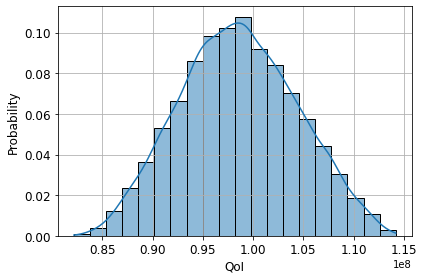

In [31]:
import seaborn as sb
from matplotlib.pyplot import Figure, Axes

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
xlabel = r"QoI"
ylabel = "Probability"
sb.histplot(qoi, stat='probability', bins=20, kde=True, ax=ax)
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
ax.tick_params(labelsize=12)
ax.grid(True)
plt.tight_layout()

conf = np.percentile(qoi, [2.5, 97.5])
msg = "\\begin{tabular}{c|c}"
msg += "\n\t \\textbf{Quantity} & \\textbf{Value} \\\\ \hline"
msg += f"\n\t Mean & {np.mean(qoi):.3e} \\\\"
msg += f"\n\t Median & {np.median(qoi):.3e} \\\\"
msg += f"\n\t Std. Deviation & {np.std(qoi):.3e} \\\\"
msg += f"\n\t 95\% Conf. Interval & [{conf[0]:.3e}, {conf[1]:.3e}] \\\\"
msg += "\n\end{tabular}"
print(msg)

print()
print(f"Mean:\t\t{np.mean(qoi):.3e}")
print(f"Std. Dev.:\t{np.std(qoi):.3e}")
print(f"Median:\t\t{np.median(qoi):.3e}")

# dirname = '/'.join(filename.split('/')[:-1])
# print(dirname)
# if not os.path.isdir(dirname):
#     os.makedirs(dirname)
plt.savefig(f"{filename}/rom_peak.pdf")